# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы.
* Контролировать добросовестность кассиров при продаже алкоголя.


**Цель:** Построить модель, которая определит приблизительный возраст человека по фотографии его лица с погрешностью не более `8` лет (порог установлен заказчиком).


**Задачи:**
1. Провести исследовательский анализ предоставленных данных.
2. Подготовить данные к обучению.
3. Обучить нейронную сеть и определить качество её работы.


**Описание данных:** Данные взяты с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/).
Состоят из папки с изображениями `/final_files` и csv-файла `labels.csv` с двумя колонками: `file_name` и `real_age` со следующей информацией:
* `file_name` - название файла с соотвествующим изображением лица покупателя в папке `/final_files`.
* `real_age` - возраст покупателя как целевой признак.

## Загрузка и анализ данных

### Загрузка исходных данных

Подключим необходимые для работы библиотеки:
* `pandas` - для работы с таблицами;
* `numpy` - для операций над массивами;
* `seaborn` - для визуализации данных;
* `tensorflow` - для решения задач построения и тренировки нейронной сети с целью автоматического нахождения и классификации образов.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.metrics import mean_absolute_error

from PIL import Image
import matplotlib.pyplot as plt

from keras.models import load_model
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

Зададим начальное значение генератора псевдослучайных чисел для вопроизводимости полученных в исследовании результатов.

In [2]:
# начальное значение генератора псевдослучайных чисел
RND = 12345

Загрузим csv-файл `labels.csv` с размеченными данными и проведём их предварительную оценку. Посмотрим на общий вид табличных данных, сводную информацию и проверим количество пропущенных значений в исследуемой таблице.

In [3]:
# чтение файла labels.csv
labels = pd.read_csv('/datasets/faces/labels.csv')
img_dir = '/datasets/faces/final_files/'

Просмотрим первые строки из таблицы с размеченными данными.

In [4]:
# просмотр первых строк из таблицы
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


Проверим количество пропущенных значений, полных дубликатов в данных и выведем общую информацию о датафрейме.

In [5]:
# подсчёт количества пропущенных значений
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

In [6]:
# подсчёт количества полных дубликатов
labels.duplicated().sum()

0

In [7]:
# вывод общей информации о датафрейме
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Для последующего удобства вывода различных данных в виде табличных строк создадим вспомогательную функцию *print_tab_row()*.

In [8]:
# вспомогательная функция вывода данных в табличной форме
def print_tab_row(descr, value, total_width=95, col_1_format='| {: <80}|', col_2_format='{: >10.2f} |', b_line=True):
    """
    input:        descr (str)        - строка-описание выводимой информации
                  value (int, float) - значение отображаемого параметра
                  total_width (int)  - общая ширина таблицы
                  col_1_format (str) - формат первого столбца
                  col_2_format (str) - формат второго столбца
                  b_line (bool)      - отрисовывание нижней границы
    output: None
    description:  Функция принимает на вход параметры и выводит в табличной форме различные данные
    """
    print('-' * total_width)
    print(col_1_format.format(descr), end='')
    print(col_2_format.format(value))
    if b_line:
        print('-' * total_width)
    return None

> * Данные успешно загружены из файла. Пропущенных значений и дубликатов в исходном наборе данных нет. В таблице с размеченными данными содержится `7591` объект из двух признаков:
>     * `file_name` наименование файла с изображениями покупателя из папки `/final_files`
>     * `real_age` реальный возраст покупателя
> * По условиям задачи требуется обучить модель, позволяющую определить возраст покупателя по его фотографии с погрешностью не более `8` лет. Указанная модель предполагается к использованию сетевым супермаркетом «Хлеб-Соль» для рекомендаций товаров посетителям и контроля кассиров при продаже алкоголя.

### Предобработка данных

Для анализа распределения возраста покупателей в полученных данных построим гистограмму распределения и диаграмму размаха для указанного признака. Создадим для этой цели вспомогательную функцию *num_feature_research()*.

In [9]:
# функция для построения парных графиков в виде гистограмм распределения частот и диаграмм размаха
def num_feature_research(data, feature, chart_title, x_lims=(0, 100)):    
    """
    input: data (pandas.Series) - данные для построения гистограммы и диаграммы размаха
           feature (str)        - наименование признака
           chart_title (str)    - наименование графика
           x_lims (tuple)       - диапазон значений по оси X
           main_df (bool)       - признак исследования основного датафрейма
    output: None
    description: Функция принимает input параметры, выводит таблицу с описательными статистиками, строит диаграмму 
                 размаха и графики распределение частот для исследуемого признака
    """
    print(f'Признак: «{feature}»')
    display(data[feature].describe())
        
    print()
    
    sns.set()
    sns.set_palette(palette='CMRmap')
    f, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw=dict(height_ratios=[1, 4]))
    f.subplots_adjust(hspace=0)

    axes[0].set_title(f'График распределения признака «{feature}» \n {chart_title}', fontsize=17)
    axes[0] = sns.boxplot(data=data, orient='h', ax=axes[0], palette='BuPu')
    axes[0].set_xlim(x_lims)
    axes[0].set_xticklabels([])

    axes[1] = sns.histplot(
        data=data,
        alpha=0.45,
        ax=axes[1],
        kde=True,
        stat='frequency',
        bins=100
    )
    axes[1].set_ylabel('Частота встречаемости', fontsize=14)
    axes[1].set_xlim(x_lims)
    plt.show();
    
    return None

Признак: «real_age»


count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

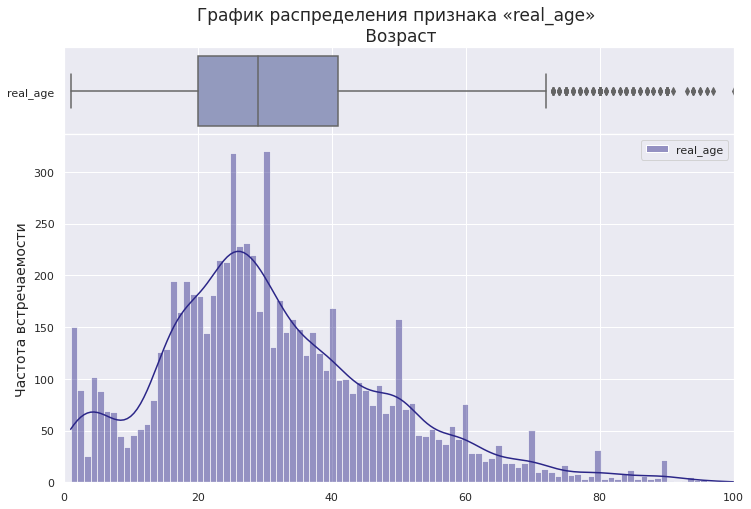

In [10]:
# оценка распределения признака возраст
num_feature_research(labels, 'real_age', 'Возраст', x_lims=(0, 100))

> * Форма распределения возраста покупателей в полученных данных близка к распределению Пуассона.
> * Медианное значение соотвесвует `29` годам, среднее значение `31.2` года, данные обладают некоторым скосом вправо.
> * Минимальный возраст `1` год, максимальный - `100` лет. Явных аномальных значений не выявлено.

### Просмотр примеров изображений

Загрузим датасет с изображениями из папки `/final_files`, создав для этого загрузчик *ImageDataGenerator*.

In [11]:
# загрузим датасет
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=img_dir,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=RND)

Found 7591 validated image filenames.


Отобразим несколько изображений из папки `/final_files`.

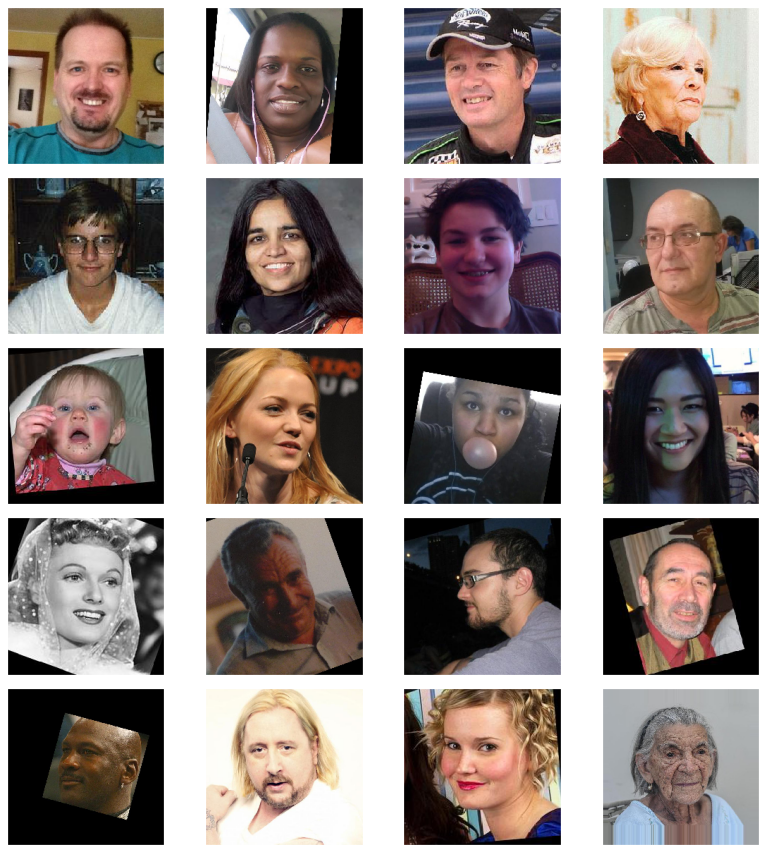

In [12]:
# отображение примеров изображений из обучающего набора данных
features, target = next(gen_flow)

fig = plt.figure(figsize=(12, 12))
for i in range(20):
    fig.add_subplot(5, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

> * Изображения в обучающем наборе самого разного качества: с очень маленькими лицами, с сильным поворотом головы, прикрытые различными объектами (очки, жвачка, руки, головные уборы). Встречаются чёрно-белые фотографии и снимки с несколькими лицами. В некоторых случаях попадаются изображения на которых даже сложно рассмотреть лицо.

### Выводы по анализу данных

> * Данные успешно загружены из файла. Пропущенных значений и дубликатов в исходном наборе данных нет. В таблице с размеченными данными содержится `7591` объект из двух признаков:
>     * `file_name` наименование файла с изображениями покупателя из папки `/final_files`
>     * `real_age` реальный возраст покупателя
> * В папке `/final_files` находится соотвествующее количество изображений в формате `JPG`, на которых будет проведено обучение модели. Изображения имеют различное качество. Встречаются фотографии очень низкого качества, на которых лица очень маленькие, или закрыты различными объектами, что может ухудшить качество обучения модели.
> * Требуется обучить модель, позволяющую определить возраст покупателя по его фотографии с погрешностью не более `8` лет.
> * Форма распределения возраста покупателей в полученных данных близка к распределению Пуассона с медианным значением равным `29` годам и средним `31.2` года. Минимальный возраст `1` год, максимальный - `100` лет. Явных аномальных значений не выявлено.

## Обучение модели

Построим и обучим свёрточную нейронную сеть  `ResNet50` на датасете с фотографиями людей. Обучение будем проводить на GPU-ускорителе, в тетради сохраним только результаты вывода модели.

### Формирование обучающего и тестового наборов данных

Для проведения обучения создадим вспомогательные функции *load_train()*, *load_test()*, *create_model()*, *train_model()*, которые выполняют следующие функции:
* `load_train(path)` - принимает путь к папке с фото, используя загрузчик *ImageDataGenerator*, возвращает обучающую выборку;
* `load_test(path)` - тоже самое для тестовой выборки;
* `create_model(input_shape)` - принимает размер входного тензора, возвращает созданую модель;
* `train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)` - обучает модель и оценивает её на тестовой выборке.

Отнормируем значения к `[0, 1]`, добавим аугментацию, приведём изображения к размеру `224×224`, количество изображений в батче - `32`.

In [13]:
# функция формирования обучающей выборки на основе загрузчика ImageDataGenerator
def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=RND)
    
    return train_gen_flow

In [14]:
# функция формирования тестовой выборки на основе загрузчика ImageDataGenerator
def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        shuffle=False,
        seed=RND)

    return test_gen_flow

In [15]:
# формирование обучающей выборки
train_data = load_train(img_dir)

Found 5694 validated image filenames.


In [16]:
# формирование тестовой выборки
test_data = load_test(img_dir)

Found 1897 validated image filenames.


In [17]:
# оценка соотношения обучающих и тестовых данных
print_tab_row(
    'Соотношение обучающего и тестового наборов данных:', 
    f'{str(round(len(train_data.filenames) / len(test_data.filenames)))}:1',
    col_2_format='{: >10} |'
)


-----------------------------------------------------------------------------------------------
| Соотношение обучающего и тестового наборов данных:                              |       3:1 |
-----------------------------------------------------------------------------------------------


> * Данные разделены на обучающий и тестовый наборы данных в соотношении `3:1`, то есть под тестовые данные выделено `25%` от общего числа объектов.

### Создание и обучение модели

Создадим модель на основе свёрточной нейронной сети, оптимизатор укажем `Adam`, типом нейросети будет `ResNet50`, обучение на функции потерь *MSE*, контрольная метрика *МАЕ*.

In [18]:
# создание модели нейронной сети
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model

In [19]:
# фукнция для обучения нейронной сети
def train_model(model, train_data, test_data, batch_size=None, epochs=50, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True
             )

    return model

Чтобы сэкономить время загрузим веса уже обученной модели нейронной сети. Если требуемый файл с весами не будет найден, то проведём обучение и сохраним веса в файл `resnet50_model.h5`.

In [20]:
# сохраниние весов обученной модели нейронной сети для сокращения времени работы ячейки при повторном перезапуске
try:
    model = create_model((224, 224, 3))
    model.load_weights('resnet50_model.h5')
except OSError:
    # обучение нейронной сети
    model = create_model((224, 224, 3))
    train_model(model, train_data, test_data)
    model.save_weights('resnet50_model.h5')

2022-08-03 13:45:09.735591: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


94781440/94765736 [==============================] - 2s 0us/step


Следующая ячейка скопирована и вставлена по результатам, полученных при обучении модели.

Сохраним и выведем значение метрики *MAE* после обучения модели.

In [22]:
# оценка модели на тестовых данных с использованием метода evaluate
mae = model.evaluate(test_data)

119/119 [==============================] - 405s 3s/step - loss: 64.1553 - mae: 5.9793


In [23]:
# получение значения метрики MAE обученной модели
print_tab_row('Значение метрики MAE после обучение модели:',  mae[1])

-----------------------------------------------------------------------------------------------
| Значение метрики MAE после обучение модели:                                     |      5.98 |
-----------------------------------------------------------------------------------------------


> * После обучения получили метрику *MAE*, равную `5.98`. Именно на столько лет ошибается в среднем модель на тестовой выборке при определении возраста клиентов. Полученное значение удовлетворяет условию задания `< 8`.

### Анализ результатов работы модели

Получим предсказания возраста покупателей от обученной модели на тестовых данных и проведём их анализ.

In [24]:
# получение предсказаний обученной модели на тестовых данных
predicts = model.predict(test_data)

Добавим столбец с предсказаниями к тестовому набору данных и сохраним полученные данные в отдельном датасете для удобства анализа.

In [25]:
# создание датасета для анализа работы обученной модели
df_res = (
    pd.concat(
        [labels.loc[test_data.index_array, :], 
            pd.Series(predicts.ravel())], axis=1).rename(columns={0:'predict_age'})
)
df_res.head(5)

,file_name,real_age,predict_age
0,000000.jpg,4,8.455135
1,000001.jpg,18,37.198505
2,000002.jpg,80,84.734711
3,000003.jpg,50,50.913818
4,000004.jpg,17,20.184546


Для проверки корректности сопоставления истинных значений предсказанным рассчитаем метрику *MAE* по столбцам `real_age` и `predict_age`. Она должна совпадать с метрикой модели на тестовых данных, которая определена в процессе обучения модели и равна `5.98`.

In [26]:
# проверка сопоставления предсказанных значений истинным по MAE
mae = mean_absolute_error(df_res['real_age'].values, df_res['predict_age'].values)

In [27]:
# значение MAE по результатам сопоставления истинных значений и предсказаний
print_tab_row('Значение метрики MAE по результатам сопоставления данных:',  mae)

-----------------------------------------------------------------------------------------------
| Значение метрики MAE по результатам сопоставления данных:                       |      5.98 |
-----------------------------------------------------------------------------------------------


Значения метрик совпадают, значит данные по объектам сопоставлены корректно.

Изучим распределения предсказанных и реальных значений возраста. Для этого создадим вспомогательную функцию *predict_distribution()*.

In [28]:
# функция построения графика распределений предсказаний и реальных значений
def predict_distribution(data, chart_title, x_lims=(0, 100)):
    """
    input: data (pandas.DataFrame)  - входные данные для построения графиков распределений предсказаний и
                                      реальных значений
           chart_title (str)        - наименование графика
    output: None
    description: Функция принимает input параметры и строит график распределения предсказанных и реальных значений
                 целевой переменной
    """
    
    labels = ['Реальные значения', 'Предсказания']
    
    sns.set()
    sns.set_palette(palette='Accent')
    f, axes = plt.subplots(2, 1, figsize=(13, 10))
    f.subplots_adjust(hspace=0)

    axes[0].set_title(chart_title, fontsize=17)
    axes[0] = sns.boxplot(data=data, orient='h', ax=axes[0])
    axes[0].set_yticklabels(labels, fontsize=13)
    axes[0].set_xlim(x_lims)
    
    axes[1] = sns.kdeplot(data=data, linewidth=2, cut=0, ax=axes[1])
    axes[1].legend(labels[::-1], fontsize=13)
    axes[1].set_ylabel('Плотность', fontsize=14)
    axes[1].set_xlim(x_lims)
    plt.show();

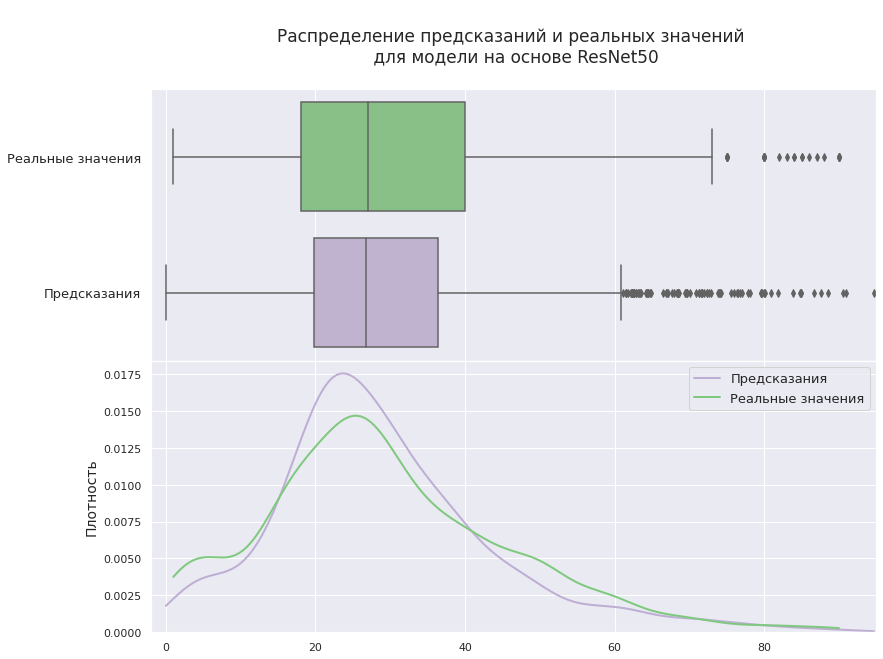

In [29]:
# отображение распределений предсказанных и реальных значений возраста покупателей
predict_distribution(
    [df_res['real_age'], df_res['predict_age']],
    '\nРаспределение предсказаний и реальных значений \n для модели на основе ResNet50\n',
    x_lims=(-2, 95)
)

Посмотрим на основные описательные статистики по реальным и предсказанным значениям возраста покупателей.

In [30]:
# просмотр описательных статистик по реальным и предсказанным значениям
df_res[['real_age', 'predict_age']].describe()

,real_age,predict_age
count,1897.000000,1897.000000
mean,29.616236,29.137520
std,16.764323,15.055784
min,1.000000,0.000000
25%,18.000000,19.844522
50%,27.000000,26.751162
75%,40.000000,36.355209
max,90.000000,94.683159


Также отобразим несколько примеров реальных и предсказанных значений возраста с привязкой к конкретным фотографиям покупателей.

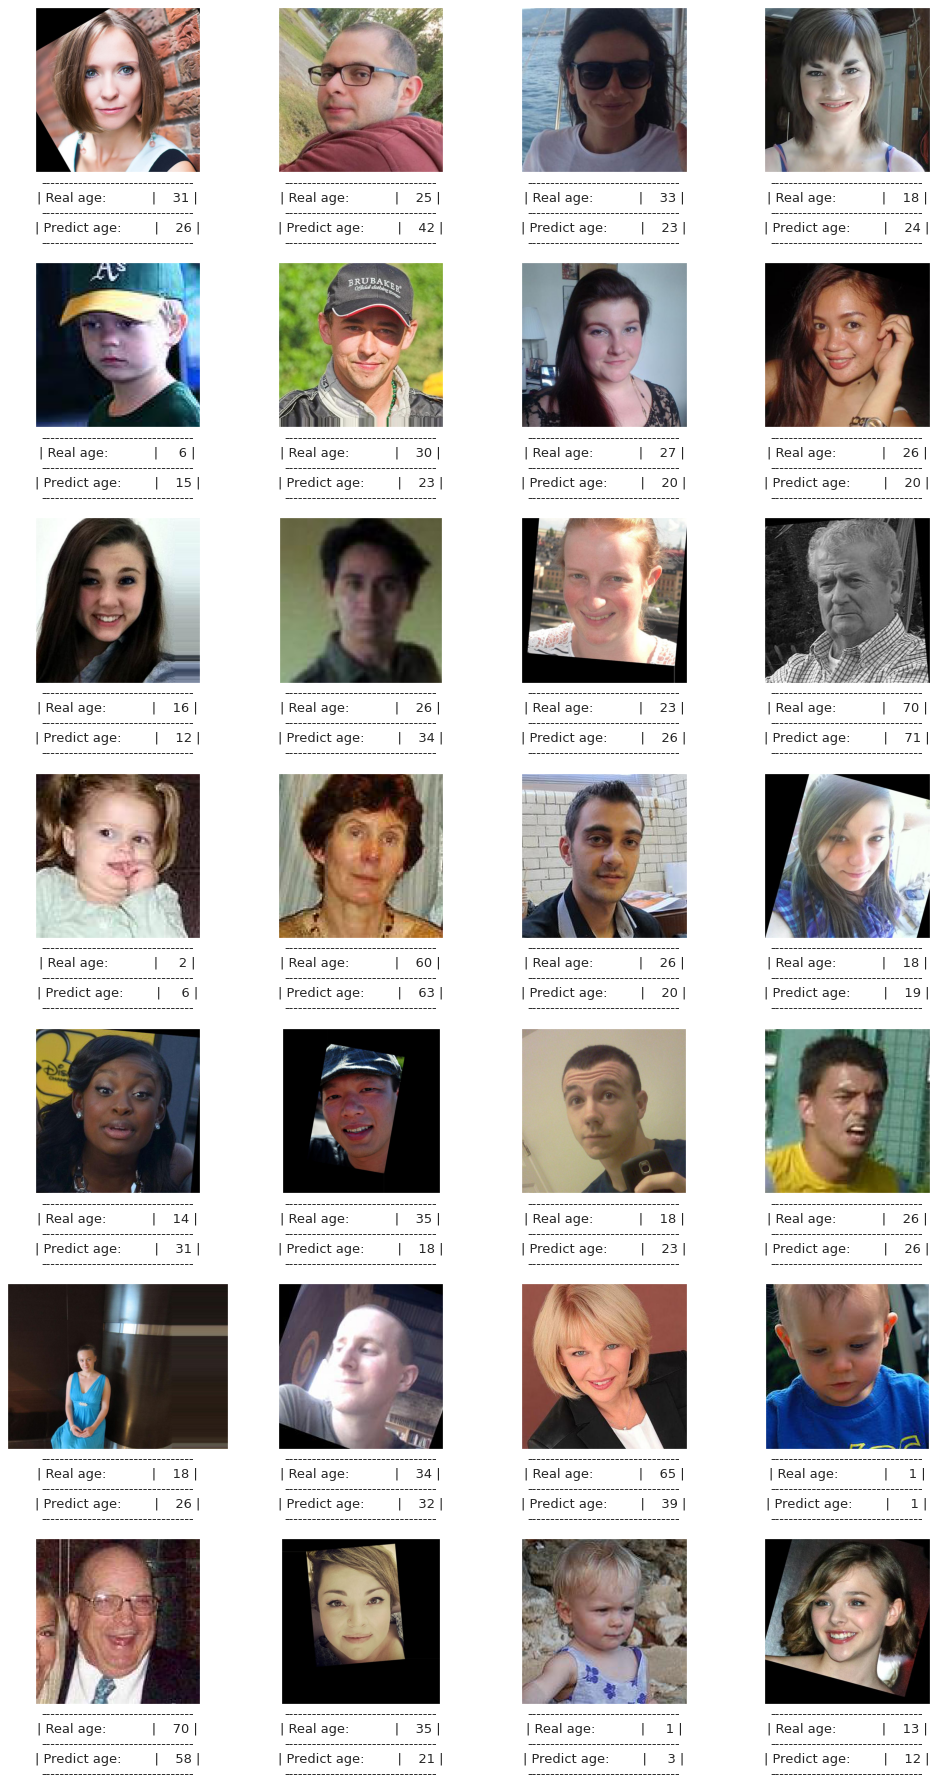

In [31]:
# отображение реальных и предсказанных значений с привязкой к конкретным фотографиям покупателей
fig = plt.figure(figsize=(15, 25))

start = 300

for i in range(start, start+28):
    fig.add_subplot(7, 4, i-start+1)
    im = Image.open(f'/datasets/faces/final_files/{df_res.loc[i, "file_name"]}')
    plt.imshow(im)
    plt.xticks([])
    x_real = '-'*33 + '\n| {: <20}|'.format('Real age:') + '{: >6d} |\n'.format(df_res.loc[i, "real_age"]) + '-'*33
    x_pred = '| {: <20}|'.format('Predict age:') + '{: >6d} |\n'.format(round(df_res.loc[i, "predict_age"])) + '-'*33
    plt.xlabel(x_real + '\n' + x_pred, fontsize=13)
    plt.yticks([])
    plt.tight_layout()

Изучим распределение ошибок предсказания модели на всём диапазоне значений целевой переменной. Для этого для каждого объекта найдём разность значений между предсказанным возрастом и реальным, а также построим график у которого по оси `X` будет находиться диапазон значений возраста посетителей, а по оси `Y` найденные значения разности.

In [32]:
# создание признака в виде разности между предсказанными и реальными значениями
df_res['diff_age'] = df_res['predict_age'] - df_res['real_age']

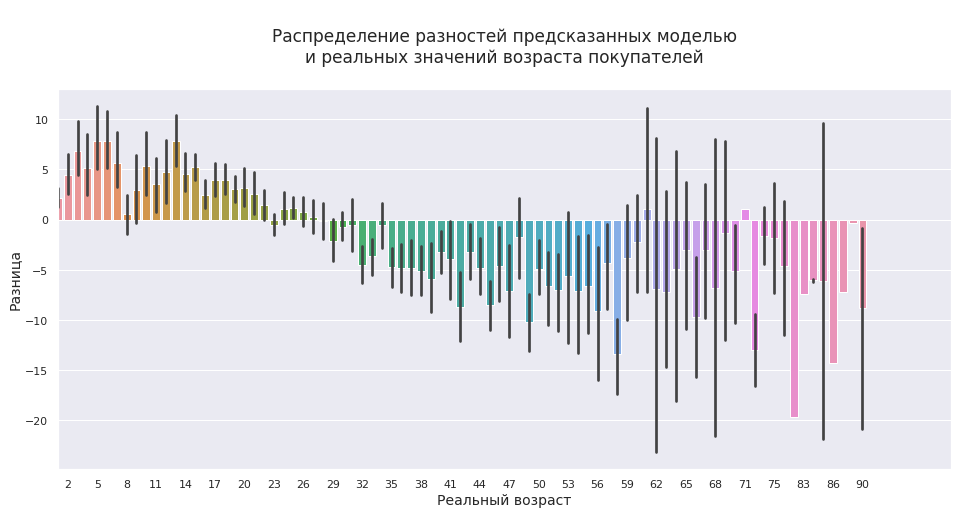

In [33]:
# построение графика распределения разностей предсказанных и реальных значений возраста посетителей
sns.set()
f, ax = plt.subplots(figsize=(16, 7))

ax.set_title('\nРаспределение разностей предсказанных моделью\nи реальных значений возраста покупателей\n', fontsize=17)

ax = sns.barplot(
    data=df_res,
    x="real_age", 
    y="diff_age",
    ax=ax
)
ax.set_ylabel('Разница', fontsize=14)
ax.set_xlabel('Реальный возраст', fontsize=14)
ax.set_xlim((0, 91))
ax.set_xticks([x for x in range(1, 91, 3)])
plt.show();

> * Распределение реальных значений характеризуется медианным значение возраста `27` и средним `29.61`. Распределение предсказанных значений характеризуется медианным значением `28.27` и средним `29.70`. Формы распределений реальных и предсказанных значений возраста покупателей обладают слабовыраженными отличиями.
> * На отображении реальных и предсказанных значений возраста покупателей с привязкой к их фотографиям видна достаточно адекватная работа модели по определению возраста. Чаще и сильнее модель ошибается в предсказаниях людей старшего возраста. Для более точного прогнозирования в данной области рекомендуется увеличить количество обучающих данных.
> * График распределения разностей предсказанных моделью и реальных значений возраста покупателей показывает, что до возраста покупателей, равного `29` годам, модель демонстрирует завышение предсказанных значения возраста по отношению к реальным, а после - к занижению. Величина ошибки предсказания, судя по графику, имеет тенденцию к увеличению с ростом реального возраста покупателей, что может свидетельствовать, как было отмечено ранее, о недостаточном количестве соотвествующих обучающих данных.

### Выводы по обучению модели

> * Для обучения моделей полученные данные разделены на обучающий и тестовый наборы в соотношениеи `3:1`, то есть под тестовые данные выделно `25%` от общего числа объектов.
> * После обучения нейронной сети `ResNet50` получили метрику *MAE*, равную `5.98`. Таким образом, модель на тестовой выборке при определении возраста клиентов ошибается в среднем на `5.98` лет. Полученное значение удовлетворяет условию задания `<8`.
> * Формы распределений реальных и предсказанных значений возраста покупателей обладают слабовыраженными отличиями. Распределение реальных значений характеризуется медианным значение возраста `27` и средним `29.61`. Распределение предсказанных значений характеризуется медианным значением `28.27` и средним `29.70`.
> * На сопоставлениях реальных и предсказанных значений возраста покупателей с их фотографиями видна достаточно адекватная работа модели по определению возраста. Чаще и сильнее модель ошибается в предсказаниях людей старшего возраста.
> * График распределения разностей предсказанных моделью и реальных значений возраста покупателей показывает, что до возраста покупателей, равного `29` годам, модель демонстрирует завышение предсказанных значения возраста по отношению к реальным, а после - к занижению. Величина ошибки предсказания, судя по графику, имеет тенденцию к увеличению с ростом реального возраста покупателей, что может свидетельствовать о недостаточном количестве соотвествующих обучающих данных.

## Общие выводы

> 1. Полученная в файлe `labels.csv` таблица с размеченными данными о возрасте посетителей загружена и проанализирована:
>    * в ней содержится `7591` объект без пропущенных значений и дубликатов;
>    * данные соотвествуют описанию и имеют следующий состав:
>        - обучающие признаки:
>            - `file_name` наименование файла с изображениями покупателя из папки `/final_files`, которая прилагается к данным
>        - целевой признак:
>            - `real_age` - реальный возраст покупателя
>    * в приложенной к данным папке `/final_files` находятся изображения различного качества (иногда достаточно низкого) в формате `JPG`, на которых было проведено обучение модели;
>    * согласно условий к задаче требовалось обучить модель, позволяющую определить возраст покупателя по его фотографии с погрешностью не более `8` лет;
>    * проведён анализ распределения целевого признака - возраста покупателей `real_age` по результатам которого установлено, что форма распределения возраста покупателей в полученных данных близка к распределению Пуассона с медианным значением равным `29` годам и средним `31.2` года, минимальный возраст `1` год, максимальный - `100` лет, явных аномальных значений не выявлено.
>
>
> 2. Выполнено обучение модели на основе свёрточной нейронной сети `ResNet50`:
>    * для обучения моделей исходные данные разделены на обучающий и тестовый наборы в соотношении `3:1`;
>    * по результатам обучения нейронной сети `ResNet50` получили на тестовой выборке метрику *MAE*, равную `5.98`, которую можно интерпретировать как то, что модель на тестовой выборке при определении возраста клиентов ошибается в среднем на `5.98` лет, что удовлетворяет условию задания `< 8.0`;
>    * сравнение форм распределений реальных и предсказанных значений возраста покупателей на графиках позволило сделать вывод об их слабовыраженных отличиях при которых распределение реальных значений характеризуется медианным значением возвраста `27` и средним `29.61`, а распределение предсказанных значений характеризуется медианным значением `28.27` и средним `29.70`;
>    * проведено сопоставление реальных и предсказанных значений возраста покупателей с их фотографиям и установлена достаточно адекватная работа модели по определению возраста, также отмечено что чаще и сильнее модель ошибается в предсказаниях людей старшего возраста;
>    * анализ графика распределения разностей предсказанных моделью и реальных значений возраста покупателей показал, что до возраста покупателей, равного `29` годам, модель преимущественно демонстрирует завышение предсказанных значения возраста по отношению к реальным, а после - к занижению, а сама величина ошибки предсказания имеет тенденцию к увеличению с ростом реального возраста покупателей, что может свидетельствовать о недостаточном количестве соотвествующих обучающих данных.
> 
> 
> В целом, обученная модель продемонстрировала достаточно хороший результат по точности. [В статье](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf) о датасете, с которым работали, полученное значение *MAE* равное `5.3`.
> Таким образом, нейронная сеть соответствует поставленной задаче сетевого супермаркета и может быть внедрена в систему слежения, что повысит средний чек покупателей за счёт рекомендации потенциально интересных товаров для возрастных групп, а также снизит риск продажи алкоголя несовершеннолетним.